# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [4]:
display(data.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'RegistrationYear'}>,
        <Axes: title={'center': 'Power'}>],
       [<Axes: title={'center': 'Kilometer'}>,
        <Axes: title={'center': 'RegistrationMonth'}>,
        <Axes: title={'center': 'NumberOfPictures'}>],
       [<Axes: title={'center': 'PostalCode'}>, <Axes: >, <Axes: >]],
      dtype=object)

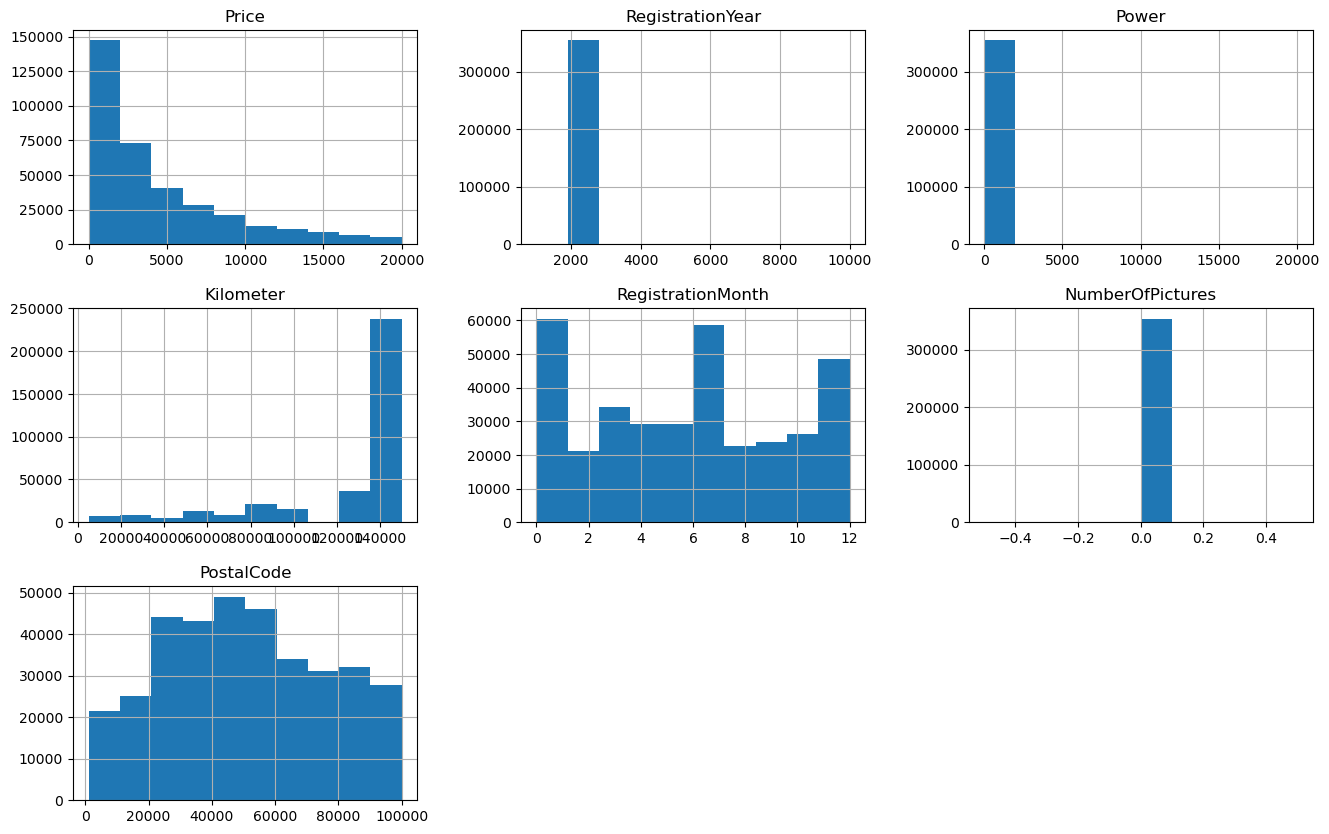

In [6]:
data.hist(figsize=(16, 10))

**Вывод:**

Есть пропуски в столбцах `VehicleType, Gearbox, Model, FuelType, Repaired`. Есть аномалии в стобце `RegistrationYear, Power`, слишком маленькие и большие значения. Видно большое количество машин ценой от 0 до 2500 евро, основная масса пробега около 140000 км

# Предобработка данных

In [7]:
data.columns = data.columns.str.lower()

In [8]:
#удалим ненужные для обучения столбцы
data = data.drop(columns=['lastseen', 'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode'])
data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [9]:
#посмотрим количество пропусков
data.isna().sum().sort_values(ascending=False)

repaired            71154
vehicletype         37490
fueltype            32895
gearbox             19833
model               19705
price                   0
registrationyear        0
power                   0
kilometer               0
brand                   0
dtype: int64

In [10]:
#заполним пропуски
data['repaired'] = data['repaired'].fillna('unknown')
data['vehicletype'] = data['vehicletype'].fillna('unknown')
data['fueltype'] = data['fueltype'].fillna('unknown')
data['gearbox'] = data['gearbox'].fillna('unknown')
data['model'] = data['model'].fillna('unknown')

In [11]:
#посмотрим количество дубликатов
data.duplicated().sum()

45040

In [12]:
#удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [13]:
#посмотрим уникальные значения столбца цены
data['price'].value_counts().sort_index().head()

0    8904
1    1075
2      12
3       7
4       1
Name: price, dtype: int64

видно много значений ниже 1

In [14]:
#посмотрим значения до 100 евро
data[data['price']<100]['price'].value_counts().sort_index().head()

0    8904
1    1075
2      12
3       7
4       1
Name: price, dtype: int64

<Axes: >

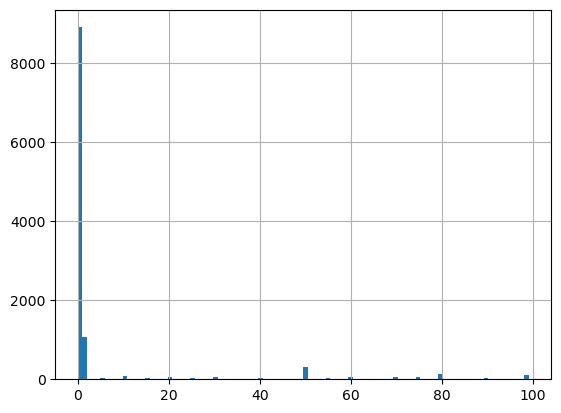

In [15]:
#построим гистограмму
data[data['price']<100]['price'].hist(bins = 100)

In [16]:
#удалим строки, где price <1
data = data[data['price']>1]

In [17]:
#посмотрим уникальные значения столбца мощности
data['power'].value_counts().sort_index()

0        32552
1           24
2            9
3            9
4           26
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 698, dtype: int64

видно много значений мощности равной 0 и есть значения больше 1000

<Axes: >

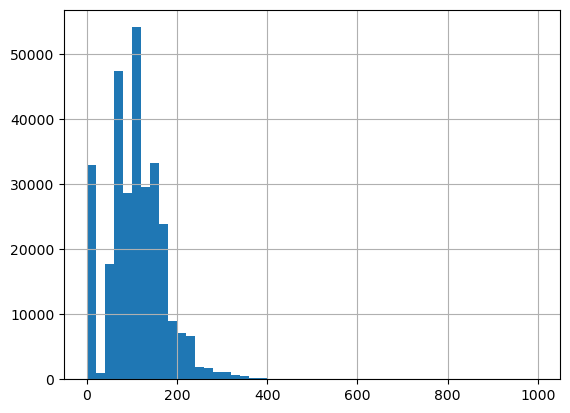

In [18]:
data[data['power']<1000]['power'].hist(bins = 50)

из гистограммы видно, что мощность больше 450, это выбросы

In [19]:
#удалим строки где мощность больше 500 и меньше 10
data = data[(data['power']<500) & (data['power']>10)]

In [20]:
#посмотрим уникальные значения столбца тип топлива
data['fueltype'].value_counts()

petrol      165024
gasoline     77087
unknown      18848
lpg           4385
cng            457
hybrid         194
other           86
electric        62
Name: fueltype, dtype: int64

In [21]:
#переименуем gasoline в petrol, потому что оба означают бензин
data['fueltype'] = data['fueltype'].replace('gasoline','petrol')

In [22]:
#посмотрим уникальные значения столбца года регистрации
data['registrationyear'].value_counts().sort_index()

1000    2
1234    1
1500    1
1800    2
1910    5
       ..
5000    6
5911    1
6000    2
8200    1
9999    1
Name: registrationyear, Length: 105, dtype: int64

<Axes: >

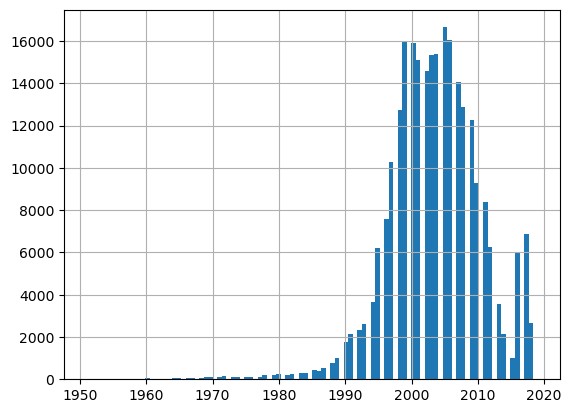

In [23]:
#построим гистограмму
data[(data['registrationyear']>1950) & (data['registrationyear']<2023)]['registrationyear'].hist(bins = 100)

In [24]:
#удалим строки с годом ниже 1960 и больше 2016
data = data[(data['registrationyear']>1960) & (data['registrationyear']<2016)]

**Вывод:**

Провели предобработку данных, приведели названия столбцов к нижнему регистру, заполнили пропуски, удалили дубликаты, аномальные значения, выбросы, лишние признаки

## Обучение моделей

In [25]:
#преобразуем столбец model
encoder = OrdinalEncoder()
encoder.fit(data[['model']])
data['model'] = encoder.transform(data[['model']])

In [26]:
#преобразуем остальные категории в числа
one_hot_list = ['vehicletype','gearbox', 'fueltype', 'brand', 'repaired']
df = data.copy()
tenure_one_hot = pd.get_dummies(df[one_hot_list], drop_first=True)
df = df.drop(one_hot_list,axis = 1)
df = df.join(tenure_one_hot, how='left')
df

,price,registrationyear,power,model,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
1,18300,2011,190,227.0,125000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,117.0,125000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,116.0,150000,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,101.0,90000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,11.0,150000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309320,1690,2004,55,101.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
309323,3200,2004,225,140.0,150000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
309326,1199,2000,101,106.0,125000,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
309327,9200,1996,102,223.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
#разделим выборки на обучающую и тестовую
features = df.drop("price", axis=1)
target = df["price"]
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(187783, 61)
(62595, 61)
(187783,)
(62595,)


In [28]:
#машстабируем признаки
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [29]:
#Преобразуем nparray в dataframe
def nptodf(data, ind, column):
    frame = pd.DataFrame(data, index = ind.index, columns = column.columns)
    return frame
features_train = nptodf(features_train, target_train, features)
features_test = nptodf(features_test, target_test, features)

# Модель линейной регрессии

In [30]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
pred_lr = model_lr.predict(features_train)
rmse_lr = mean_squared_error(target_train, pred_lr)**0.5
print("RMSE LinearRegression:", rmse_lr)

RMSE LinearRegression: 2795.2506937227213
CPU times: total: 1.72 s
Wall time: 398 ms


In [31]:
%%time

parameters_lr = {'fit_intercept':[True,False],  
              'copy_X':[True, False]}
model_lr_cv = GridSearchCV(model_lr,
                    param_grid = parameters_lr, 
                    cv=4, 
                    scoring = 'neg_root_mean_squared_error', 
                    verbose=False)
model_lr_cv.fit(features_train, target_train)
model_lr_cv.best_params_

CPU times: total: 27.2 s
Wall time: 4.62 s


{'copy_X': True, 'fit_intercept': True}

In [32]:
%%time

model_lr_tuned = LinearRegression(**model_lr_cv.best_params_).fit(features_train, target_train)

CPU times: total: 2.16 s
Wall time: 369 ms


In [33]:
%%time

pred_lr_tuned = model_lr_tuned.predict(features_train)

CPU times: total: 297 ms
Wall time: 37.9 ms


In [34]:
rmse_scores_lr_cv = -cross_val_score(model_lr_cv.best_estimator_, 
                                     features_train, 
                                     target_train, 
                                     cv=4, 
                                     scoring='neg_root_mean_squared_error')
average_rmse_lr_cv = np.mean(rmse_scores_lr_cv)
print("Average RMSE LinearRegression:", average_rmse_lr_cv)

Average RMSE LinearRegression: 2796.1291300497583


In [35]:
importances_lr = pd.DataFrame(data={
    'Attribute': features_train.columns,
    'Importance': model_lr_tuned.coef_
})
importances_lr = importances_lr.sort_values(by='Importance', ascending=False)

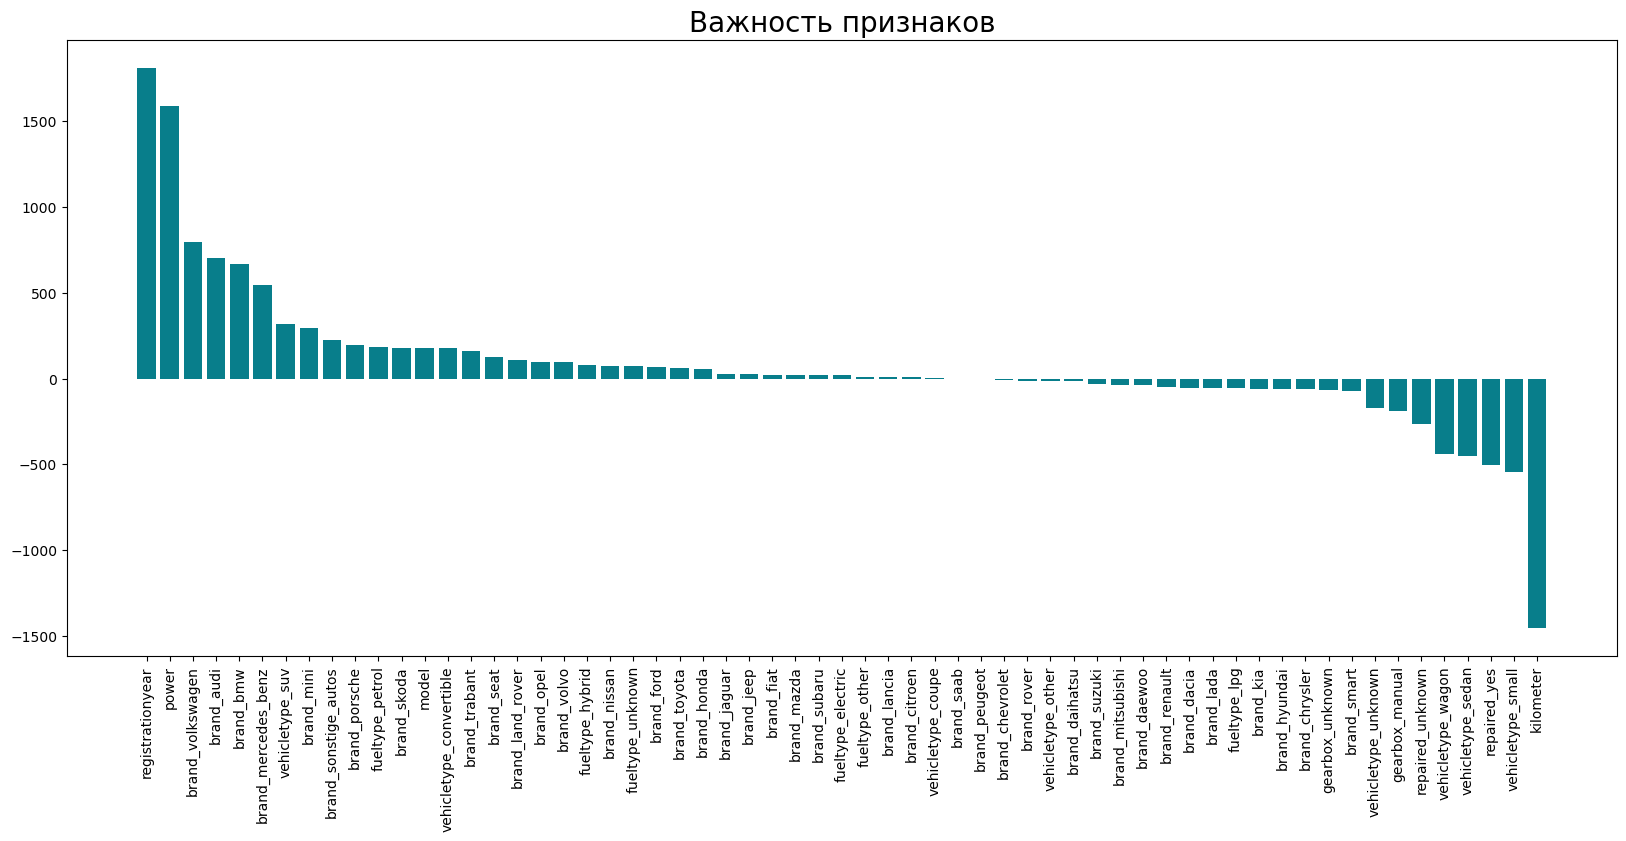

In [36]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(x=importances_lr['Attribute'], height=importances_lr['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Модель LightGBM

In [37]:
%%time

model_lgb = LGBMRegressor(random_state=12345)
model_lgb.fit(features_train, target_train)
pred_lgb = model_lgb.predict(features_train)
rmse_lgb = mean_squared_error(target_train, pred_lgb)**0.5
print("RMSE LightGBM:",rmse_lgb)

RMSE LightGBM: 1659.1262185728644
CPU times: total: 6.89 s
Wall time: 1.32 s


In [38]:
%%time

parameters_lgb = {"n_estimators": [200, 700],
               "max_depth": [6, 14]
              }

model_lgb_cv = GridSearchCV(model_lgb,
                          param_grid=parameters_lgb,
                          scoring='neg_root_mean_squared_error',
                          cv=4,
                          n_jobs=1,
                          verbose=False)

model_lgb_cv.fit(features_train, target_train)
model_lgb_cv.best_params_

CPU times: total: 2min 24s
Wall time: 26.6 s


{'max_depth': 14, 'n_estimators': 700}

In [39]:
%%time

model_lgb_tuned = LGBMRegressor(**model_lgb_cv.best_params_).fit(features_train, target_train)

CPU times: total: 11.7 s
Wall time: 2.15 s


In [40]:
%%time

pred_lgb_tuned = model_lgb_tuned.predict(features_train)

CPU times: total: 6.78 s
Wall time: 1.15 s


In [41]:
rmse_scores_lgb_cv = -cross_val_score(model_lgb_cv.best_estimator_, 
                                     features_train, 
                                     target_train, 
                                     cv=4,
                                     scoring='neg_root_mean_squared_error')
average_rmse_lgb_cv = np.mean(rmse_scores_lgb_cv)
print("Average RMSE LightGBM:", average_rmse_lgb_cv)

Average RMSE LightGBM: 1590.5536873550477


In [42]:
importances_lgb = pd.DataFrame(data={
    'Attribute': features_train.columns,
    'Importance': model_lgb_tuned.feature_importances_
})
importances_lgb = importances_lgb.sort_values(by='Importance', ascending=False)

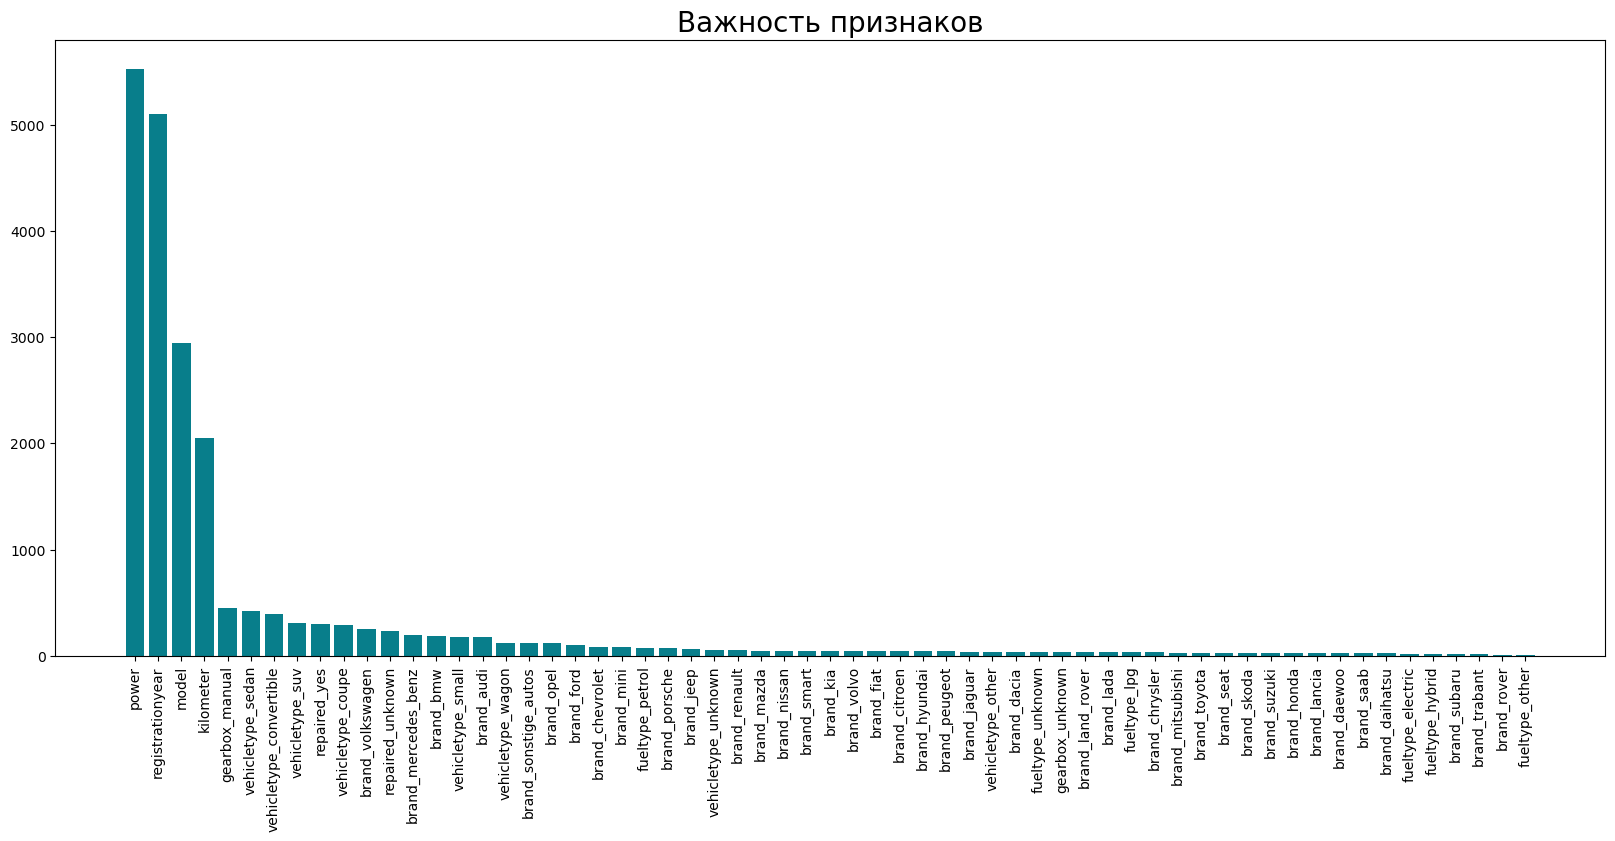

In [43]:
plt.bar(x=importances_lgb['Attribute'], height=importances_lgb['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Модель CatBoost

In [44]:
%%time

model_cbr = CatBoostRegressor(logging_level='Silent').fit(features_train, target_train)

CPU times: total: 1min 28s
Wall time: 9.67 s


In [45]:
%%time

pred_cbr = model_cbr.predict(features_train)

CPU times: total: 391 ms
Wall time: 50.9 ms


In [46]:
rmse_cbr = mean_squared_error(target_train, pred_cbr)**0.5
print('RMSE CatBoostRegressor:', rmse_cbr)

RMSE CatBoostRegressor: 1530.4163505447573


In [47]:
%%time

parameters_cb = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]
              }

model_CBR = CatBoostRegressor(loss_function='RMSE', 
                                    eval_metric = 'RMSE', 
                                    logging_level='Silent')

model_cbr_cv = GridSearchCV(model_CBR,
                         param_grid = parameters_cb, 
                         cv = 4, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error')
model_cbr_cv.fit(features_train, target_train)
model_cbr_cv.best_params_

CPU times: total: 1min 56s
Wall time: 4min 31s


{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [48]:
%%time

model_cbr_tuned = CatBoostRegressor(**model_cbr_cv.best_params_, logging_level='Silent').fit(features_train, target_train)

CPU times: total: 2min 1s
Wall time: 14 s


In [49]:
%%time

pred_cbr_tuned = model_cbr_tuned.predict(features_train)

CPU times: total: 531 ms
Wall time: 59.8 ms


In [50]:
rmse_scores_cbr_cv = -cross_val_score(model_cbr_cv.best_estimator_, 
                                     features_train, 
                                     target_train, 
                                     cv=4, 
                                     scoring='neg_root_mean_squared_error')
average_rmse_cbr_cv = np.mean(rmse_scores_cbr_cv)
print("Average RMSE CatBoost:", average_rmse_cbr_cv) 

Average RMSE CatBoost: 1580.7555349375054


In [51]:
importances_cat = pd.DataFrame(data={
    'Attribute': features_train.columns,
    'Importance': model_cbr_tuned.feature_importances_
})
importances_cat = importances_cat.sort_values(by='Importance', ascending=False)

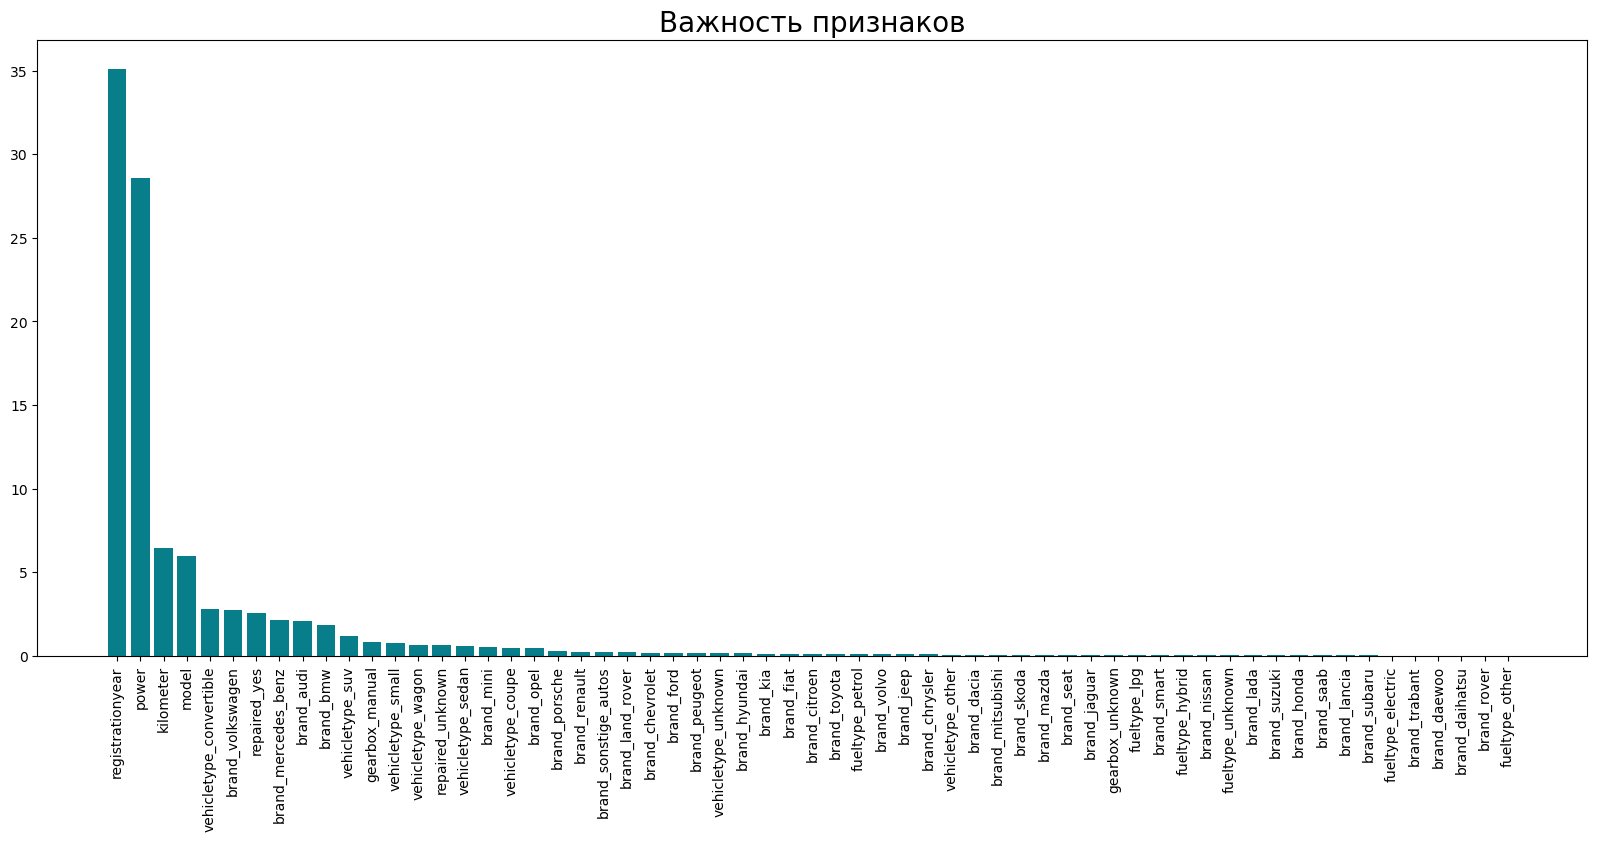

In [52]:
plt.bar(x=importances_cat['Attribute'], height=importances_cat['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Анализ моделей

In [53]:
print('LinearRegression:', end = '')
print()
print(f'RMSE:{average_rmse_lr_cv}, скорость предсказания: 112 ms, время обучения: 3.9 s')
print('LightGBM:', end = '')
print()
print(f'RMSE:{average_rmse_lgb_cv}, скорость предсказания: 15.1 s, время обучения: 40.7 s')
print('Catboost:', end = '')
print()
print(f'RMSE:{average_rmse_cbr_cv}, скорость предсказания: 467 ms, время обучения: 36.1 s')

LinearRegression:
RMSE:2796.1291300497583, скорость предсказания: 112 ms, время обучения: 3.9 s
LightGBM:
RMSE:1590.5536873550477, скорость предсказания: 15.1 s, время обучения: 40.7 s
Catboost:
RMSE:1580.7555349375054, скорость предсказания: 467 ms, время обучения: 36.1 s


лучшей моделью по RMSE, времени обучения и предсказания, оказалась модель Catboost

In [54]:
%%time
final_cbr_pred = model_cbr_tuned.predict(features_test)

CPU times: total: 188 ms
Wall time: 25.9 ms


In [55]:
final_cbr_rmse = mean_squared_error(target_test, final_cbr_pred)**0.5
print("RMSE: %.2f" % final_cbr_rmse)

RMSE: 1560.70


**Вывод:**

Лучшей модель оказалась `Catboost`, RMSE: 1443.25, скорость предсказания: 467 ms, время обучения: 36.1 s

**Общий вывод:**

- Загрузили, изучили данные
- Провели предобработку данных
- Подготовили данные для обучения
- Обучили три модели: Линейную регрессию, LightGBM, Catboost
- Проанализировали время обучения, время предсказания и качество моделей
- Опираясь на критерии заказчика, выбрали лучшую модель, проверили её качество на тестовой выборке

 Лучшей моделью оказалась `Catboost`:
- RMSE = 1443.25
- скорость предсказания = 467 ms
- время обучения = 36.1 s